In [1]:
import numpy as np


import numpy as np
import SimpleITK as sitk
from collections import defaultdict

# Load the segmentation NIfTI file
file_path = "/Users/seandmello/Downloads/OASIS-TRT-20-10_DKT31_CMA_labels_in_MNI152.nii.gz"
image = sitk.ReadImage(file_path)

# Convert to NumPy array
data = sitk.GetArrayFromImage(image)
print(data)
np.random.seed(100)

# Load the label map of brain
file_path = "/Users/seandmello/Documents/Segmentation_8-BrainLabelMap-label_1.nrrd"
image = sitk.ReadImage(file_path)
print("printing image")
print(image)


#initialize variables

tumour_weight = 1
normal_weight = 1



# Convert to NumPy array
label_map = sitk.GetArrayFromImage(image)
def add_tumor_to_data(data1, label_map, radius):
    # Find all brain coordinates (label == 1)
    brain_coords = np.argwhere(label_map == 1)  # Assuming 1 represents brain tissue in your segmentation
    
    # Randomly select a point as the tumor center
    tumor_center = brain_coords[np.random.randint(len(brain_coords))]
    
    # Get the shape of the data matrix
    shape = data1.shape
    
    # Add the tumor as a sphere around the tumor center
    for dz in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            for dx in range(-radius, radius + 1):
                if dz**2 + dy**2 + dx**2 <= radius**2:  # Check if within the sphere
                    z, y, x = tumor_center + np.array([dz, dy, dx])
                    if (
                        0 <= z < shape[0] and
                        0 <= y < shape[1] and
                        0 <= x < shape[2] and
                        label_map[z, y, x] == 1  # Ensure the tumor stays within brain tissue
                    ):
                        data1[z, y, x] = 999  # Assign label 999 for the tumor

    return data1, tumor_center


# Parameters for the tumor
tumor_radius = 3  # Radius of the tumor

# Implant the tumor into the data matrix
print("Implanting a random tumor into the data matrix...")
data_with_tumor, tumor_center = add_tumor_to_data(data,label_map, tumor_radius)
unique_labels = np.unique(data_with_tumor)
print(unique_labels)

print(f"Tumor implanted at {tumor_center} with radius {tumor_radius}.")

# Define the size of the region to inspect
region_size = 5  # Number of voxels to include in each direction

# Get the tumor center
z, y, x = tumor_center

# Extract the region around the tumor
z_min = max(0, z - region_size)
z_max = min(data_with_tumor.shape[0], z + region_size + 1)
y_min = max(0, y - region_size)
y_max = min(data_with_tumor.shape[1], y + region_size + 1)
x_min = max(0, x - region_size)
x_max = min(data_with_tumor.shape[2], x + region_size + 1)

# Extract the region
region = data_with_tumor[z_min:z_max, y_min:y_max, x_min:x_max]

# Print the region
print("Region around the tumor:")
print(region)

unique_labels = np.unique(region)
print(unique_labels)
tumor_voxels_count = np.count_nonzero(region == 999)
print(tumor_voxels_count)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
printing i

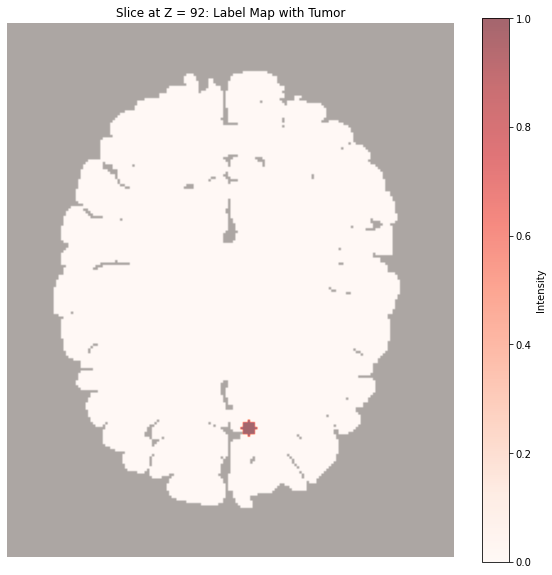

In [2]:
import matplotlib.pyplot as plt

# Choose a slice along the z-axis near the tumor center
slice_index = tumor_center[0]  # Use the z-coordinate of the tumor center

# Extract slices from both label_map and data
label_map_slice = label_map[slice_index, :, :]
tumor_slice = data_with_tumor[slice_index, :, :]

# Create a mask for the tumor
tumor_mask = (tumor_slice == 999)  # Only show regions labeled 999 (tumor)

# Plot the label map and tumor
plt.figure(figsize=(10, 10))

# Show the label map in one color (e.g., grayscale)
plt.imshow(label_map_slice, cmap="gray", alpha=0.8, label="Label Map")

# Overlay the tumor in a different color (e.g., red)
plt.imshow(tumor_mask, cmap="Reds", alpha=0.6, label="Tumor")

# Add a legend and title
plt.title(f"Slice at Z = {slice_index}: Label Map with Tumor")
plt.colorbar(label="Intensity")
plt.axis("off")
plt.show()

In [3]:
import numpy as np
from collections import defaultdict

# Function to perform Bresenham's line algorithm for 3D
def bresenham_line_3d(start, end):
    points = []
    x1, y1, z1 = start
    x2, y2, z2 = end

    # Calculate deltas
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    dz = abs(z2 - z1)

    # Determine the direction of movement
    xs = 1 if x2 > x1 else -1
    ys = 1 if y2 > y1 else -1
    zs = 1 if z2 > z1 else -1

    # Driving axis is x-axis
    if dx >= dy and dx >= dz:
        p1 = 2 * dy - dx
        p2 = 2 * dz - dx
        while x1 != x2:
            points.append((x1, y1, z1))
            x1 += xs
            if p1 >= 0:
                y1 += ys
                p1 -= 2 * dx
            if p2 >= 0:
                z1 += zs
                p2 -= 2 * dx
            p1 += 2 * dy
            p2 += 2 * dz

    # Driving axis is y-axis
    elif dy >= dx and dy >= dz:
        p1 = 2 * dx - dy
        p2 = 2 * dz - dy
        while y1 != y2:
            points.append((x1, y1, z1))
            y1 += ys
            if p1 >= 0:
                x1 += xs
                p1 -= 2 * dy
            if p2 >= 0:
                z1 += zs
                p2 -= 2 * dy
            p1 += 2 * dx
            p2 += 2 * dz

    # Driving axis is z-axis
    else:
        p1 = 2 * dy - dz
        p2 = 2 * dx - dz
        while z1 != z2:
            points.append((x1, y1, z1))
            z1 += zs
            if p1 >= 0:
                y1 += ys
                p1 -= 2 * dz
            if p2 >= 0:
                x1 += xs
                p2 -= 2 * dz
            p1 += 2 * dy
            p2 += 2 * dx

    # Add the last point
    points.append((x2, y2, z2))
    return points

# Expand the beam with a radius
def add_radius_around_points(points, radius, shape):
    expanded_points = set()
    for z, y, x in points:
        for dz in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                for dx in range(-radius, radius + 1):
                    if dz**2 + dy**2 + dx**2 <= radius**2:  # Within the sphere
                        nz, ny, nx = z + dz, y + dy, x + dx
                        if 0 <= nz < shape[0] and 0 <= ny < shape[1] and 0 <= nx < shape[2]:
                            expanded_points.add((nz, ny, nx))
    return expanded_points

# Create beam through tumor with adjustable angle and ensuring it passes through the tumor center
def create_beam_with_angle_and_tumor(start_point, tumor_center, shape):
    # Calculate the direction vector from the start point to the tumor center
    direction = np.array(tumor_center) - np.array(start_point)
    
    # Normalize the direction vector
    direction = direction / np.linalg.norm(direction)

    # Define the start point as given
    start_z, start_y, start_x = start_point

    # Calculate an end point far enough in the direction of the beam
    # Extend the beam to the limits of the matrix
    end_z = min(shape[0] - 1, int(start_z + direction[0] * 1000))  # Large enough multiplier to span the matrix
    end_y = min(shape[1] - 1, int(start_y + direction[1] * 1000))
    end_x = min(shape[2] - 1, int(start_x + direction[2] * 1000))
    
    return tuple(start_point), (end_z, end_y, end_x)

# Example usage
start_point = (0, 0, 0)  # Starting point of the beam (can be set manually)

# Get the shape of the matrix (data.shape)
matrix_shape = data.shape  # Ensure 'data' is defined, or replace with your matrix

# Create the start and end points for the beam
start_point, end_point = create_beam_with_angle_and_tumor(start_point, tumor_center, matrix_shape)

# Trace the beam path
print(f"Tracing the beam from {start_point} to {end_point}...")
# Generate the beam in two segments to ensure tumor center inclusion
segment1 = bresenham_line_3d(start_point, tumor_center)  # From start to tumor center
segment2 = bresenham_line_3d(tumor_center, end_point)    # From tumor center to end point
# Combine the two segments, ensuring the tumor center is included
beam_points = segment1 + segment2
# Remove duplicates if necessary
beam_points = list(dict.fromkeys(beam_points))

# Expand the beam with a radius
radius = 5  # Adjustable radius size
expanded_beam_points = add_radius_around_points(beam_points, radius, data.shape)

distances = [np.linalg.norm(np.array(tumor_center) - np.array(point)) for point in expanded_beam_points]
min_distance = min(distances)
print(f"Minimum distance from tumor center to expanded beam: {min_distance}")

# Assign Gaussian intensity
sigma = 10  # Standard deviation for Gaussian
I_0 = 1.0  # Peak intensity
intensity_per_segmentation = defaultdict(float)

for z, y, x in expanded_beam_points:
    label = data_with_tumor[z, y, x]
    # Calculate distance from the beam center
    distances = [np.sqrt((z - bz)**2 + (y - by)**2 + (x - bx)**2) for bz, by, bx in beam_points]
    min_distance = min(distances)
    intensity = I_0 * np.exp(-min_distance**2 / (2 * sigma**2))
    intensity_per_segmentation[label] += intensity

# Output the total intensity for each segmentation
for label, intensity in intensity_per_segmentation.items():
    print(f"Segmentation {label}: Total intensity = {intensity:.2f}")
    

# Output the total intensity for each segmentation
for label, intensity in intensity_per_segmentation.items():
    print(f"Segmentation {label}: Total intensity = {intensity:.2f}")
    
    
# Show intensity for segmentation 999
intensity_999 = intensity_per_segmentation.get(999, 0)  # Default to 0 if not present
print(f"Intensity for segmentation 999: {intensity_999:.2f}")

Tracing the beam from (0, 0, 0) to (181, 217, 181)...
Minimum distance from tumor center to expanded beam: 0.0
Segmentation 0.0: Total intensity = 18983.46
Segmentation 45.0: Total intensity = 2246.66
Segmentation 1028.0: Total intensity = 741.69
Segmentation 2007.0: Total intensity = 684.73
Segmentation 53.0: Total intensity = 706.43
Segmentation 52.0: Total intensity = 677.43
Segmentation 2016.0: Total intensity = 240.73
Segmentation 1026.0: Total intensity = 490.01
Segmentation 43.0: Total intensity = 554.49
Segmentation 999.0: Total intensity = 114.80
Segmentation 44.0: Total intensity = 172.10
Segmentation 50.0: Total intensity = 398.01
Segmentation 60.0: Total intensity = 294.63
Segmentation 54.0: Total intensity = 85.31
Segmentation 58.0: Total intensity = 9.00
Segmentation 2009.0: Total intensity = 7.14
Segmentation 1002.0: Total intensity = 24.73
Segmentation 2002.0: Total intensity = 4.47
Segmentation 4.0: Total intensity = 7.15
Segmentation 0.0: Total intensity = 18983.46
Se

In [4]:
import json

# Load the JSON file with segmentation data
with open("/Users/seandmello/Downloads/regions_with_priority.json", "r") as f:
    segmentation_data = json.load(f)

# Example of segmentation_data structure:
# segmentation_data = {
#     "1002": ["left caudal anterior cingulate", 8],
#     "1003": ["left caudal middle frontal", 8],
#     "1005": ["left cuneus", 6],
#     # ...
# }
# Initialize a dictionary to store weighted intensities
weighted_intensities = {}

# Multiply intensity by the priority score for each segmentation
for label, intensity in intensity_per_segmentation.items():
    label_int = str(int(label))  # Convert the label to an integer for consistent lookup
    if label_int in segmentation_data:
        priority_score = segmentation_data[label_int][1]  # Extract priority score
        weighted_intensity = intensity * (priority_score * 0.1)
        weighted_intensities[label_int] = weighted_intensity
    else:
        print(f"Warning: Label {label_int} not found in segmentation data.")

# Output the weighted intensities
for label, weighted_intensity in weighted_intensities.items():
    segmentation_name = segmentation_data[label][0]
    print(f"Segmentation {label} ({segmentation_name}): Weighted intensity = {weighted_intensity:.2f}")


Segmentation 45 (right cerebellum exterior): Weighted intensity = 1123.33
Segmentation 1028 (left superior frontal): Weighted intensity = 593.35
Segmentation 2007 (right fusiform): Weighted intensity = 410.84
Segmentation 53 (right hippocampus): Weighted intensity = 565.14
Segmentation 52 (right pallidum): Weighted intensity = 541.94
Segmentation 2016 (right parahippocampal): Weighted intensity = 168.51
Segmentation 1026 (left rostral anterior cingulate): Weighted intensity = 343.01
Segmentation 43 (right lateral ventricle): Weighted intensity = 110.90
Segmentation 44 (right inferior lateral ventricle): Weighted intensity = 34.42
Segmentation 50 (right caudate): Weighted intensity = 318.40
Segmentation 60 (right ventral DC): Weighted intensity = 176.78
Segmentation 54 (right amygdala): Weighted intensity = 59.72
Segmentation 58 (right accumbens area): Weighted intensity = 6.30
Segmentation 2009 (right inferior temporal): Weighted intensity = 4.28
Segmentation 1002 (left caudal anterior

In [5]:
excluded_labels = {999, 0}  # Set of labels to exclude
total_weighted_intensity = sum(
    weighted_intensity 
    for label, weighted_intensity in weighted_intensities.items() 
    if label not in excluded_labels
)

print(f"Total weighted intensity (excluding segmentations 999 and 0): {total_weighted_intensity:.2f}")



Total weighted intensity (excluding segmentations 999 and 0): 4481.72


In [6]:

# Show intensity for segmentation 999
intensity_999 = intensity_per_segmentation.get(999, 0)  # Default to 0 if not present
print(f"Intensity for segmentation 999: {intensity_999:.2f}")

Intensity for segmentation 999: 114.80


In [7]:


objective_function_score = intensity_999 * tumour_weight *(-1)+ (total_weighted_intensity * normal_weight)

print (f"Score for beam position is: {objective_function_score}")

Score for beam position is: 4366.915118279554


In [8]:
### FINAL CODE ####

import numpy as np
from collections import defaultdict
import json


import numpy as np


import numpy as np
import SimpleITK as sitk
from collections import defaultdict

# Load the segmentation NIfTI file
file_path = "/Users/seandmello/Downloads/OASIS-TRT-20-10_DKT31_CMA_labels_in_MNI152.nii.gz"
image = sitk.ReadImage(file_path)

# Convert to NumPy array
data = sitk.GetArrayFromImage(image)
print(data)
np.random.seed(100)

# Load the label map of brain
file_path = "/Users/seandmello/Documents/Segmentation_8-BrainLabelMap-label_1.nrrd"
image = sitk.ReadImage(file_path)



def bresenham_line_3d(start, end):
    points = []
    x1, y1, z1 = start
    x2, y2, z2 = end

    # Calculate deltas
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    dz = abs(z2 - z1)

    # Determine the direction of movement
    xs = 1 if x2 > x1 else -1
    ys = 1 if y2 > y1 else -1
    zs = 1 if z2 > z1 else -1

    # Driving axis is x-axis
    if dx >= dy and dx >= dz:
        p1 = 2 * dy - dx
        p2 = 2 * dz - dx
        while x1 != x2:
            points.append((x1, y1, z1))
            x1 += xs
            if p1 >= 0:
                y1 += ys
                p1 -= 2 * dx
            if p2 >= 0:
                z1 += zs
                p2 -= 2 * dx
            p1 += 2 * dy
            p2 += 2 * dz

    # Driving axis is y-axis
    elif dy >= dx and dy >= dz:
        p1 = 2 * dx - dy
        p2 = 2 * dz - dy
        while y1 != y2:
            points.append((x1, y1, z1))
            y1 += ys
            if p1 >= 0:
                x1 += xs
                p1 -= 2 * dy
            if p2 >= 0:
                z1 += zs
                p2 -= 2 * dy
            p1 += 2 * dx
            p2 += 2 * dz

    # Driving axis is z-axis
    else:
        p1 = 2 * dy - dz
        p2 = 2 * dx - dz
        while z1 != z2:
            points.append((x1, y1, z1))
            z1 += zs
            if p1 >= 0:
                y1 += ys
                p1 -= 2 * dz
            if p2 >= 0:
                x1 += xs
                p2 -= 2 * dz
            p1 += 2 * dy
            p2 += 2 * dx

    # Add the last point
    points.append((x2, y2, z2))
    return points

# Expand the beam with a radius
def add_radius_around_points(points, radius, shape):
    expanded_points = set()
    for z, y, x in points:
        for dz in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                for dx in range(-radius, radius + 1):
                    if dz**2 + dy**2 + dx**2 <= radius**2:  # Within the sphere
                        nz, ny, nx = z + dz, y + dy, x + dx
                        if 0 <= nz < shape[0] and 0 <= ny < shape[1] and 0 <= nx < shape[2]:
                            expanded_points.add((nz, ny, nx))
    return expanded_points

# Create beam through tumor with adjustable angle and ensuring it passes through the tumor center
def create_beam_with_angle_and_tumor(start_point, tumor_center, shape):
    # Calculate the direction vector from the start point to the tumor center
    direction = np.array(tumor_center) - np.array(start_point)
    
    # Normalize the direction vector
    direction = direction / np.linalg.norm(direction)

    # Define the start point as given
    start_z, start_y, start_x = start_point

    # Calculate an end point far enough in the direction of the beam
    # Extend the beam to the limits of the matrix
    end_z = min(shape[0] - 1, int(start_z + direction[0] * 1000))  # Large enough multiplier to span the matrix
    end_y = min(shape[1] - 1, int(start_y + direction[1] * 1000))
    end_x = min(shape[2] - 1, int(start_x + direction[2] * 1000))
    
    return tuple(start_point), (end_z, end_y, end_x)


# Convert to NumPy array
label_map = sitk.GetArrayFromImage(image)
def add_tumor_to_data(data1, label_map, radius):
    # Find all brain coordinates (label == 1)
    brain_coords = np.argwhere(label_map == 1)  # Assuming 1 represents brain tissue in your segmentation
    
    # Randomly select a point as the tumor center
    tumor_center = brain_coords[np.random.randint(len(brain_coords))]
    
    # Get the shape of the data matrix
    shape = data1.shape
    
    # Add the tumor as a sphere around the tumor center
    for dz in range(-radius, radius + 1):
        for dy in range(-radius, radius + 1):
            for dx in range(-radius, radius + 1):
                if dz**2 + dy**2 + dx**2 <= radius**2:  # Check if within the sphere
                    z, y, x = tumor_center + np.array([dz, dy, dx])
                    if (
                        0 <= z < shape[0] and
                        0 <= y < shape[1] and
                        0 <= x < shape[2] and
                        label_map[z, y, x] == 1  # Ensure the tumor stays within brain tissue
                    ):
                        data1[z, y, x] = 999  # Assign label 999 for the tumor

    return data1, tumor_center

def calculate_objective_function(start_point, sigma, I_0, tumor_center, tumor_weight, normal_weight, data, data_with_tumor, segmentation_file_path, beam_radius=5,target_dose):
    """
    Calculate the objective function value for a beam configuration.

    Parameters:
        start_point (tuple): Starting position of the beam (z, y, x).
        sigma (float): Standard deviation for Gaussian intensity.
        I_0 (float): Peak intensity.
        tumor_center (tuple): Coordinates of the tumor center (z, y, x).
        tumor_weight (float): Weight for tumor intensity.
        normal_weight (float): Weight for normal tissue intensity.
        data (ndarray): Matrix representing segmentations.
        data_with_tumor (ndarray): Matrix with tumor-included segmentations.
        segmentation_file_path (str): Path to the JSON file with segmentation data.
        beam_radius (int, optional): Radius for expanding the beam. Default is 5.

    Returns:
        float: Objective function value.
    """
    # Load segmentation data
    with open(segmentation_file_path, "r") as f:
        segmentation_data = json.load(f)

    # Create beam with angle through tumor center
    matrix_shape = data.shape
    direction = np.array(tumor_center) - np.array(start_point)
    direction = direction / np.linalg.norm(direction)

    end_point = (
        min(matrix_shape[0] - 1, int(start_point[0] + direction[0] * 1000)),
        min(matrix_shape[1] - 1, int(start_point[1] + direction[1] * 1000)),
        min(matrix_shape[2] - 1, int(start_point[2] + direction[2] * 1000))
    )

    # Trace the beam path
    segment1 = bresenham_line_3d(start_point, tumor_center)
    segment2 = bresenham_line_3d(tumor_center, end_point)
    beam_points = list(dict.fromkeys(segment1 + segment2))  # Remove duplicates

    # Expand the beam with a radius
    expanded_beam_points = add_radius_around_points(beam_points, beam_radius, data.shape)

    # Calculate intensities
    intensity_per_segmentation = defaultdict(float)
    for z, y, x in expanded_beam_points:
        label = data_with_tumor[z, y, x]
        distances = [np.sqrt((z - bz)**2 + (y - by)**2 + (x - bx)**2) for bz, by, bx in beam_points]
        min_distance = min(distances)
        intensity = I_0 * np.exp(-min_distance**2 / (2 * sigma**2))
        intensity_per_segmentation[label] += intensity

    # Calculate weighted intensities
    weighted_intensities = {}
    for label, intensity in intensity_per_segmentation.items():
        label_str = str(int(label))
        if label_str in segmentation_data:
            priority_score = segmentation_data[label_str][1]
            weighted_intensity = intensity * (priority_score * 0.1)
            weighted_intensities[label_str] = weighted_intensity

    # Exclude specific segmentations
    excluded_labels = {"999", "0"}
    total_weighted_intensity = sum(
        weighted_intensity
        for label, weighted_intensity in weighted_intensities.items()
        if label not in excluded_labels
    )
    total_weighted_intensity
    # Tumor intensity
    intensity_999 = intensity_per_segmentation.get(999, 0)
    print(intensity_999)
    # Calculate objective function
    #objective_function_score = intensity_999 * tumor_weight * (-1) + (total_weighted_intensity * normal_weight)
    objective_function_score =  (abs(target_dose - intensity_999)) * tumor_weight + (total_weighted_intensity * normal_weight)
    return objective_function_score


# Parameters for the tumor
tumor_radius = 3  # Radius of the tumor

# Implant the tumor into the data matrix
print("Implanting a random tumor into the data matrix...")
data_with_tumor, tumor_center = add_tumor_to_data(data,label_map, tumor_radius)
unique_labels = np.unique(data_with_tumor)

print(f"Tumor implanted at {tumor_center} with radius {tumor_radius}.")

#creating objective function
tumour_weight = 1
normal_weight = 1
target_done = 400

#paramaters
sigma = 10  # Standard deviation for Gaussian
I_0 = 1.0  # Peak intensity
start_point = (0,0,0)
beam_radius = 5



objective = calculate_objective_function(start_point, sigma, I_0, tumor_center, tumour_weight, normal_weight, data, data_with_tumor, "/Users/seandmello/Downloads/regions_with_priority.json", beam_radius,target_dose)

objective

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Implanting

4366.915118279554